In [113]:
from useful_functions import *
import ast
from varname import nameof
savePNG = True ## Changes matplotlib backend to save plots as pgf (default:True)
if savePNG:
    mpl.use("agg")
    plotExt = str('.png')
elif not savePNG:
    mpl.use("pgf")
    mpl.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,})
    plotExt = str('.pgf')

notebookPlotFlag = True ## Changes Jupyter plotting backend (default:True)
if notebookPlotFlag:
    %matplotlib notebook
elif not notebookPlotFlag:
    %matplotlib inline

In [114]:
tess_2020bpi = pd.read_csv('JhaData/TESS_SN2020bpi.csv')[::2]
tess_2020bpi['mjd_0'] = tess_2020bpi['mjd'] - tess_2020bpi['mjd'].min()
tess_2020bpi.head()

BTJD          mjd         cts      e_cts  bkg_model  raw_flux  \
0  1870.44408  58869.94408  -5339.0302  1368.8706  1502.1435 -0.030663   
2  1870.46491  58869.96491  -6841.1413  1375.3282  1502.1435 -0.039290   
4  1870.48574  58869.98574  -2219.7583  1400.7610  1501.2344 -0.012748   
6  1870.50658  58870.00658 -10843.6913  1370.6601  1501.2344 -0.062277   
8  1870.52741  58870.02741  -9069.4821  1365.9754  1501.2344 -0.052088   

   e_raw_flux  bkg_model_flux      flux    e_flux    mjd_0  
0    0.007862        0.008627  0.001725  0.007501  0.00000  
2    0.007899        0.008627 -0.006505  0.007536  0.02083  
4    0.008045        0.008622  0.018823  0.007675  0.04166  
6    0.007872        0.008622 -0.028431  0.007510  0.06250  
8    0.007845        0.008622 -0.018710  0.007485  0.08333

In [115]:
ztf_2020bpi = pd.read_csv('JhaData/ztf_SN2020bpi.csv')
ztf_2020bpi['mjd_0'] = ztf_2020bpi['mjd'] - tess_2020bpi['mjd'].min()
## Note: setting the zero value of mjd_0 to that of TESS for consitency 
ztf_2020bpi['e_flux_tuple'] = ztf_2020bpi['e_flux']
ztf_2020bpi['e_flux'] = [
    np.mean(ast.literal_eval(flux))
    for flux in ztf_2020bpi['e_flux'].to_numpy()
                        ]

ztf_2020bpi.head()

BTJD           mjd      magap  sig_magap      flux    e_flux  \
0  1879.870567  58879.370567  19.729799     0.2218  0.014224  0.002926   
1  1881.011065  58880.511065  19.959801     0.2436  0.011509  0.002604   
2  1881.031343  58880.531343  19.473101     0.1538  0.018018  0.002561   
3  1881.843854  58881.343854  19.660400     0.2291  0.015163  0.003223   
4  1882.032546  58881.532546  19.363001     0.1425  0.019941  0.002625   

       mjd_0                                    e_flux_tuple  
0   9.426487    (0.002628163767600394, 0.003223832161130714)  
1  10.566985  (0.0023129338055085068, 0.0028946976073013723)  
2  10.587263   (0.0023797689104727814, 0.002741920034638759)  
3  11.399774   (0.0028844699689605166, 0.003562099310207071)  
4  11.588466    (0.00245268546717093, 0.0027966740782900297)

In [123]:
import emcee
import corner
from multiprocessing import Pool

def get_fullparam(theta, thetaKeys):
    params = {'t0':7, 
              'a':0.0025,
              'sigma':0,
              'power':1.4}
#     print('params1: ', params)
#     print('theta: ',theta)
#     print('dict:',dict(zip(thetaKeys,theta)))
    params.update(dict(zip(thetaKeys,theta)))
#     print('params2: ', params)
    ## .update() adds keyed values as well; might need 
    ## to find new method to account for this
    #print(params)
    return params

def lc_model(theta,thetaKeys, data, curveModel='standard'):
    thetaDict = get_fullparam(theta,thetaKeys)
    if curveModel =='standard':
        var = (data['e_flux']**2 + thetaDict['sigma']**2)
        model = [0 if t <= thetaDict['t0'] else
                 thetaDict['a'] * (t - thetaDict['t0'])**thetaDict['power'] 
                 for t in data['mjd_0']]
    return model, var

def gaussian(theta, thetaKeys,data):
    thetaDict = get_fullparam(theta,thetaKeys)
    curveFrac = (1/(thetaDict['std']*np.sqrt(2*np.pi)))
    curveExp = -0.5((thetaDict['mjd_0']-thetaDict['mean'])/thetaDict['mean'])**2
    curve = curveFrac * np.exp(curveExp)
    return curve 

def log_prior(theta, thetaKeys):
    
    nparam = len(theta)
    thetaDict = get_fullparam(theta, thetaKeys)
    
    logpr = 0.

    if thetaDict['sigma'] < 0:
        return -np.inf

    if thetaDict['t0'] < 0:
        return -np.inf
    
    if thetaDict['t0'] > 10:
        return -(100)**np.float(thetaDict['t0'])
    
    if thetaDict['a'] <= 0:
        return -(100)**np.float(1/thetaDict['power'])
    
    if thetaDict['power'] <= 1:
        return -(100)**np.float(1/thetaDict['power'])
    
    if thetaDict['power'] >= 2.5:
        return -(1000)**np.float(thetaDict['power'])
    return logpr

def log_likelihood(theta, thetaKeys, data, curveModel='standard'):
    
    thetaDict = get_fullparam(theta, thetaKeys)
    #print(thetaDict)
    model,var = lc_model(thetaDict.values(),thetaDict.keys(),data, curveModel='standard')
    
    logl = -0.5 * (np.sum(np.log(2 * np.pi * var) + 
                            ((data['flux'] - model)**2 / var) ))
        
    return logl

    
def log_posterior(theta, thetaKeys, data, curveModel='standard'):
    
    logpr = log_prior(theta, thetaKeys)
    
    if logpr == -np.inf:
        return logpr
    else:
        return logpr + log_likelihood(theta, thetaKeys, data, curveModel='standard')

def doMCMC(data, guess, scale, 
           nwalkers=100, nburn=1500, nsteps=3000, curveModel='standard'):
    '''
    Takes data which contains mjd and flux data
    and performs an mcmc fit on it
    '''
    ndim = len(guess)
    assert ndim == len(scale)

    starting_guesses = np.swapaxes(list({
        k:(np.random.randn(nwalkers)*scale[k]+v)
        for k,v in guess.items()}.values()),0,1)
#     print(starting_guesses)
    print('sampling...')
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, threads=-1, 
                                    args=[list(guess.keys()),data,curveModel])
    sampler.run_mcmc(starting_guesses, nsteps,progress="notebook")
    print('done')
    
    
    samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))
    sampler.reset()
    tlabels = list(guess.keys())
    figcorner = corner.corner(samples, labels=tlabels[0:ndim],
                    show_titles=True, title_fmt=".6f", verbose=True,
                    title_kwargs={"fontsize": 11}, label_kwargs={"fontsize": 14})
    ## plot lc model with samples medians (or randomly pick 10 samples [better])

    return samples

In [117]:
def plot_lc_model(theta,data,cutoff=16.75):
    if data.mjd_0[0] == tess_2020bpi.mjd_0[0]:
        title = 'TESS'
    elif data.mjd_0[0] == ztf_2020bpi.mjd_0[0]:
        title = 'ZTF'
    else:
        title = "I AM ERROR."
    
    lc_mod, lc_var = lc_model(theta.values(),theta.keys(),data[data.mjd_0 <= cutoff])

    fig,ax = plt.subplots(figsize=(8,8))

    ax.scatter(data[data.mjd_0 <= cutoff].mjd_0, 
               lc_mod,label='model')
    ax.scatter(data[data.mjd_0 <= cutoff].mjd_0, 
               data[data.mjd_0 <= cutoff].flux,alpha=0.25,label=title)
    divider = make_axes_locatable(ax)

    ax2 = divider.append_axes("bottom",size="25%",pad=0.03)
    ax.figure.add_axes(ax2)
    ax2.plot(data[data.mjd_0 <= cutoff].mjd_0, 
             data[data.mjd_0 <= cutoff].flux- lc_mod,
             color='grey')
    ax2.grid()

    # anchText1 = mpl.offsetbox.AnchoredText('TESS Scale Factor: '+
    # np.str(np.around(fluxOptParams.x[0],3))+
    #          '\n'+'TESS Vertical Shift: '+np.str(np.around(fluxOptParams.x[1],3)),loc=4)
    # ax.add_artist(anchText1)
    # ax.legend(loc=2)
    
    plt.xlabel("mjd-"+str(round(tess_2020bpi.mjd.min())));
    ax.set_ylabel("flux");
    ax.legend()
    ax.set_title(title);
    fig.show();

In [118]:
def plot_lc_guesses(data, guess, scale, cutoff=16.75, 
                    nwalkers=100, nburn=1500, nsteps=3000,numMods=10):
    ## pretty sloppy implementation, could make this a part of the function directly
    if data.mjd_0[0] == tess_2020bpi.mjd_0[0]:
        title = 'TESS'
    elif data.mjd_0[0] == ztf_2020bpi.mjd_0[0]:
        title = 'ZTF'
    else:
        title = "I AM ERROR."
        
    fits = doMCMC(data[data.mjd_0 <= cutoff], guess, scale, nwalkers, nburn, nsteps)
    
    fig,ax = plt.subplots(figsize=(8,8))
    ax.scatter(data[data.mjd_0 <= cutoff].mjd_0, 
               data[data.mjd_0 <= cutoff].flux,alpha=0.25,label=title)
    tRange = np.linspace(0,cutoff,cutoff*48)
    np.random.seed()
    np.random.seed(np.random.randint(low=0,high=1006))
    indices = [np.random.randint(low=0,high=len(fits[:,0])-1) 
               for i in range(0,numMods-1)]
    for i in indices:
        thetaVals = fits[i]
        #print(thetaVals)
        thetaDict = get_fullparam(thetaVals, guess.keys())
        dummyPD = pd.DataFrame()
        dummyPD['mjd_0'] = tRange
        dummyPD['e_flux'] = np.zeros(np.size(tRange))
        #print(thetaDict)
        model, var = lc_model(thetaVals,guess.keys(),dummyPD)
        ax.plot(tRange,model)
        
        
    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("bottom",size="25%",pad=0.03)
    ax.figure.add_axes(ax2)
    thetaVals = [np.median(fits[:,i]) for i in range(0,len(fits[0]))]
    model, var = lc_model(thetaVals,guess.keys(),data[data.mjd_0 <= cutoff])
    ax2.plot(data[data.mjd_0 <= cutoff].mjd_0, 
             data[data.mjd_0 <= cutoff].flux- model,
             color='grey')
    ax2.grid()
    plt.xlabel("mjd-"+str(round(tess_2020bpi.mjd.min())));
    ax.set_ylabel("flux");
    ax.legend()
    ax.set_title(title);
    return [fits, fits[indices]]

sampling...



done


<IPython.core.display.Javascript object>


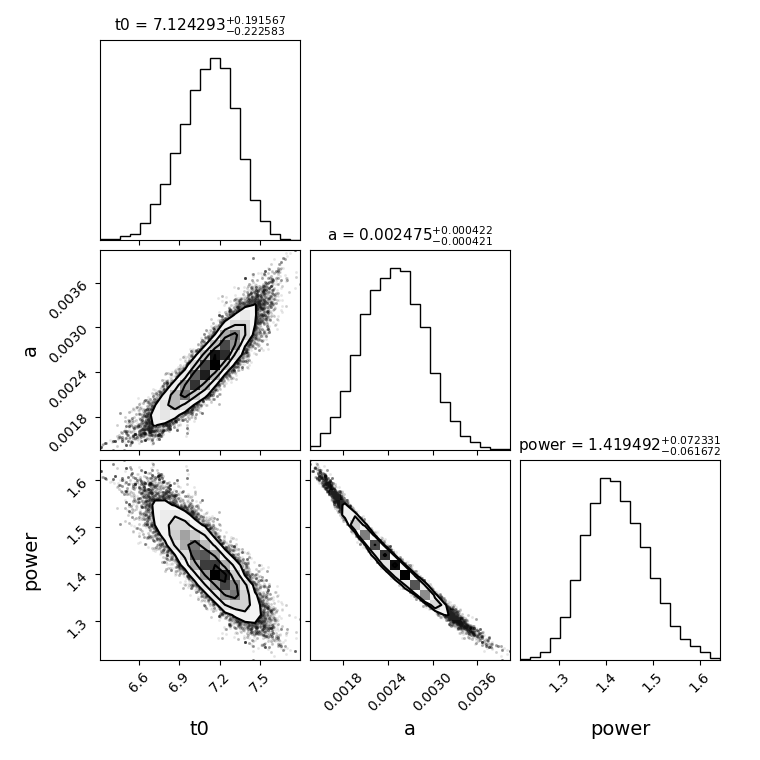

<IPython.core.display.Javascript object>


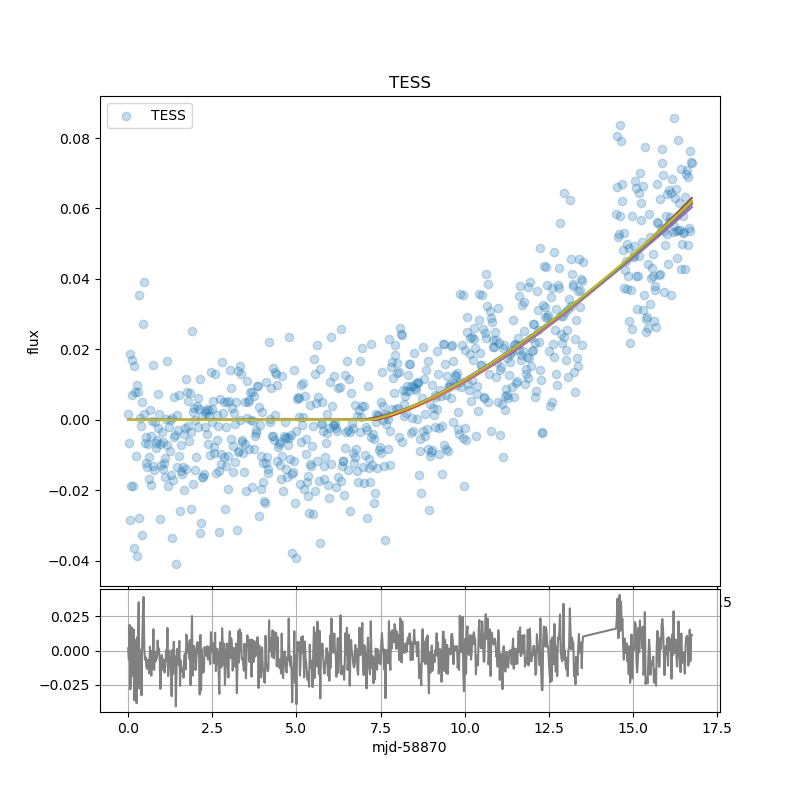

In [119]:
guess = {'t0':7.1, 'a':0.0025,'power':1.45} ## t0, a, sigma, power
scale = {'t0':0.2, 'a':0.0001,'power':0.1}
# sampData = doMCMC(tess_2020bpi[tess_2020bpi.mjd_0 <= 16.75],guess, scale, 
#                   nwalkers=50,nburn=300,nsteps=500)
test = plot_lc_guesses(tess_2020bpi, guess, scale, 
                cutoff=16.75, nwalkers=25,nburn=3000,nsteps=5000,numMods=10);

sampling...



done


<IPython.core.display.Javascript object>


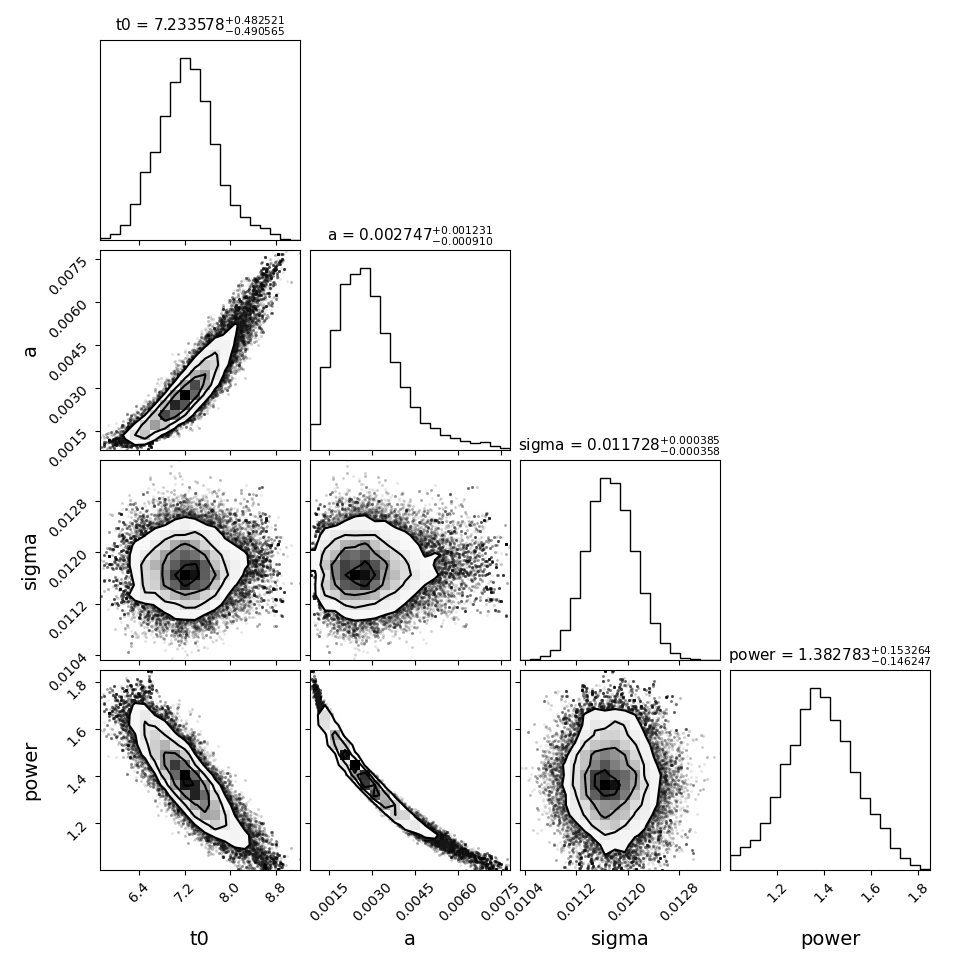

<IPython.core.display.Javascript object>


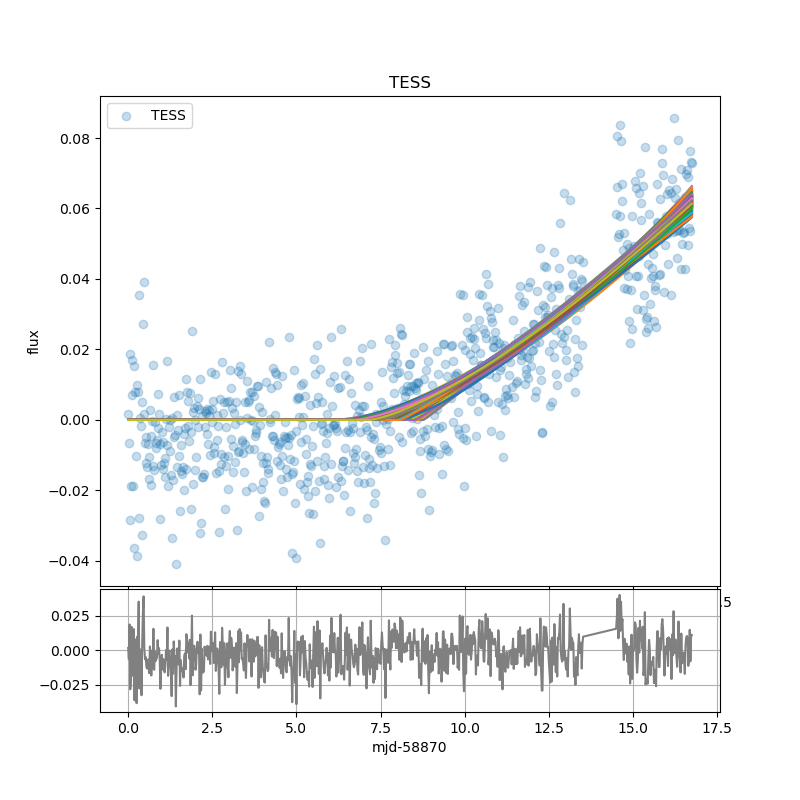

In [120]:
guess = {'t0':7.1, 'a':0.0025,'sigma':0.2,'power':1.45} ## t0, a, sigma, power
scale = {'t0':0.2, 'a':0.0001,'sigma':0.01,'power':0.1}
# sampData = doMCMC(tess_2020bpi[tess_2020bpi.mjd_0 <= 16.75],guess, scale, 
#                   nwalkers=50,nburn=300,nsteps=500)
test = plot_lc_guesses(tess_2020bpi, guess, scale, 
                cutoff=16.75, nwalkers=50,nburn=3000,nsteps=5000,numMods=200);

In [33]:
#plot_lc_guesses(data, guess, scale, cutoff, nwalkers=100, nburn=1500, nsteps=3000)

In [34]:
# guess = {'t0':5,'a':9e-4,'power':1.7}
# cutoff = 16.75
# plot_lc_model(guess,tess_2020bpi,cutoff)
# plot_lc_model(guess,ztf_2020bpi,cutoff)

In [35]:
# guess = {'t0':5,'a':4.5e-4,'power':2}
# cutoff = 14
# plot_lc_model(guess,tess_2020bpi,cutoff)
# plot_lc_model(guess,ztf_2020bpi,cutoff)

In [36]:
# guess = {'t0':5,'a':4.5e-4,'power':2}
# cutoff = 14
# plot_lc_model(guess,tess_2020bpi,cutoff)
# plot_lc_model(guess,ztf_2020bpi,cutoff)

In [70]:
# guess = {'t0':7.111060668809373,'a':0.002450366876860027,'power':1.4245618012322618}
# cutoff = 16.75
# plot_lc_model(guess,tess_2020bpi,cutoff)
# plot_lc_model(guess,ztf_2020bpi,cutoff)

In [20]:
# plt.scatter(tess_2020bpi[tess_2020bpi.flux >=0].mjd_0.rolling(48).median(),tess_2020bpi[tess_2020bpi.flux >=0].flux.rolling(48).median(),
#            )
# plt.scatter(tess_2020bpi[tess_2020bpi.flux <=0].mjd_0.rolling(48).median(),tess_2020bpi[tess_2020bpi.flux <=0].flux.rolling(48).median(),
#            )
# plt.xlim(0,17)
# plt.grid()

# len(tess_2020bpi[tess_2020bpi.flux <=0][tess_2020bpi.mjd_0 <28])/len(tess_2020bpi[tess_2020bpi.mjd_0 <28])

sampling...



done


<IPython.core.display.Javascript object>


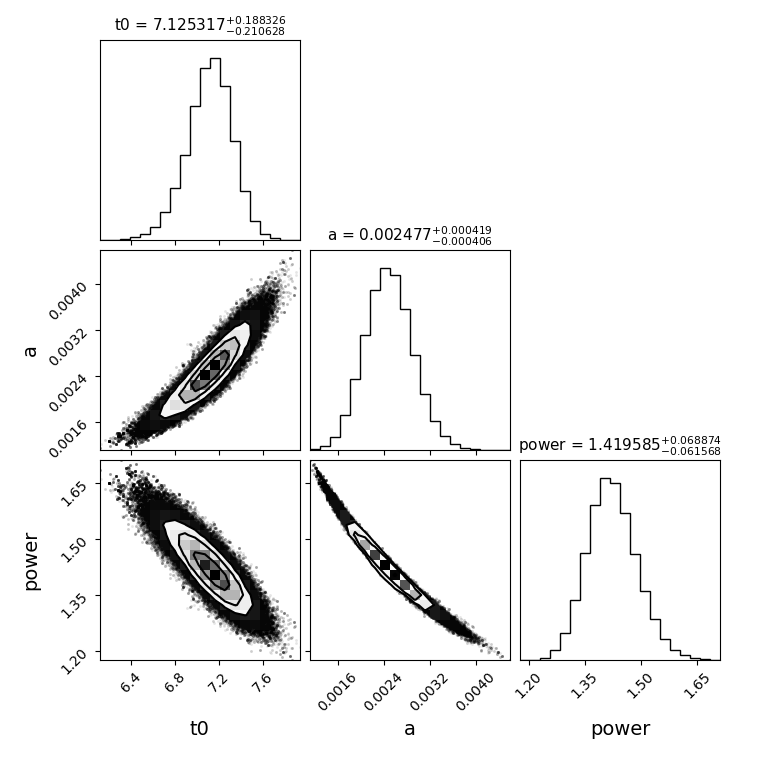

<IPython.core.display.Javascript object>


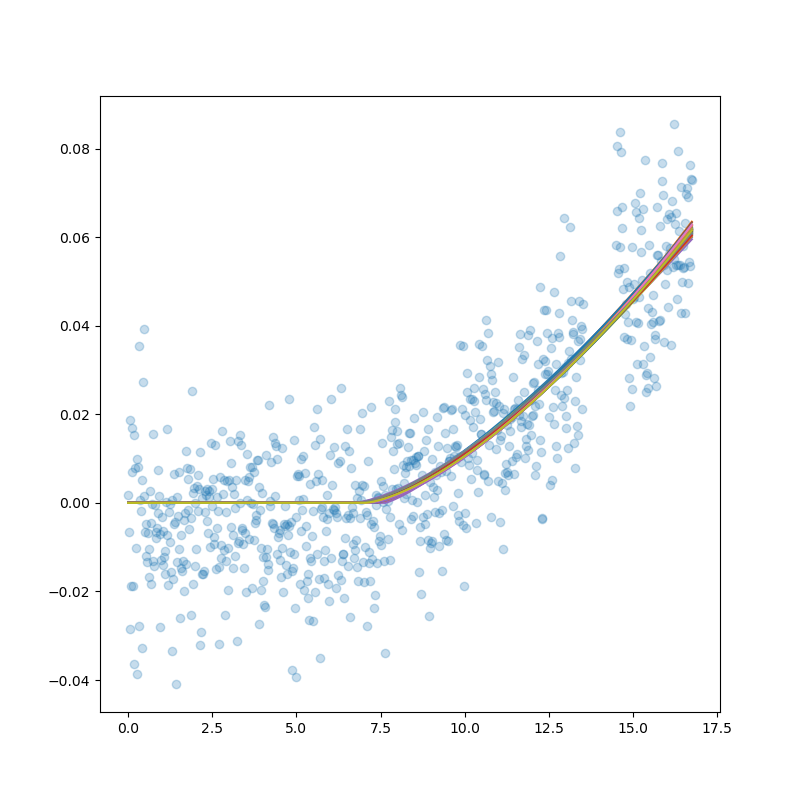

In [23]:
# guess = {'t0':7, 'a':0.0025,'power':1.4} ## t0, a, sigma, power
# scale = {'t0':0.2, 'a':0.0001,'power':0.1}
# # sampData = doMCMC(tess_2020bpi[tess_2020bpi.mjd_0 <= 16.75],guess, scale, 
# #                   nwalkers=50,nburn=300,nsteps=500)
# plot_lc_guesses(tess_2020bpi, guess, scale, 
#                 cutoff=16.75, nwalkers=250,nburn=3000,nsteps=5000,numMods=50);

sampling...



done


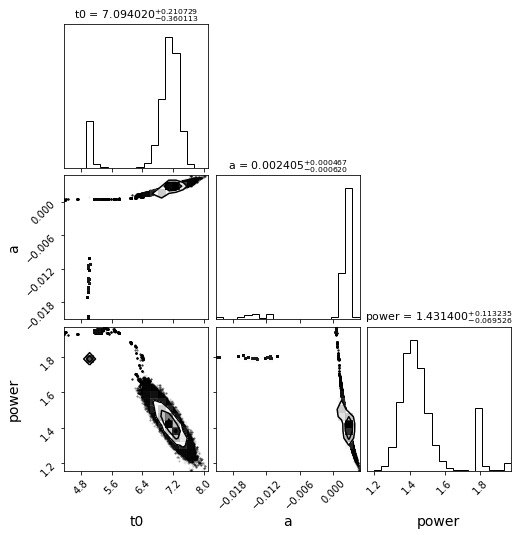

In [92]:
# guess = {'t0':5, 'a':0.001,'power':1.8} ## t0, a, sigma, power
# scale = {'t0':0.01, 'a':0.01,'power':0.01}
# doMCMC(tess_2020bpi[tess_2020bpi.mjd_0 <= 16.75],guess, scale, nwalkers=150,nburn=3000,nsteps=10000);

sampling...



done


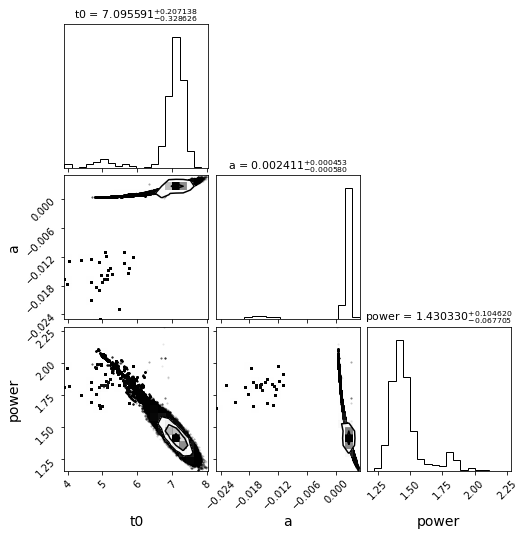

In [96]:
# guess = {'t0':5, 'a':0.001,'power':1.8} ## t0, a, sigma, power
# scale = {'t0':0.5, 'a':0.01,'power':0.1}
# doMCMC(tess_2020bpi[tess_2020bpi.mjd_0 <= 16.75],guess, scale, nwalkers=250,nburn=2500,nsteps=20000);